# FVM1D

## 输入库

In [36]:
import numpy as np
import time
import matplotlib.pyplot as plt
import os
import shutil
#import matplotlib.gridspec as gridspec

## 功能函数

### 格式

In [37]:
def Scheming(Schemer,*args):
  def warpper(*args):
    return Schemer(*args)
  return warpper


@Scheming
def REC_WENO(U,bc,Limiter):
  Nb = U.shape[0] + 1
  UL = np.zeros((Nb))
  UR = np.zeros((Nb))

  if bc == 'Periodic':
    UE = np.concatenate((U[-3:],U,U[:3]))
  else:
    ones = np.ones((3))
    UE = np.concatenate((U[0]*ones,U,U[-1:]*ones))

  for j in range(0, Nb):
    UL[j] = Limiting(Limiter)(UE[j:j+5])
    UR[j] = Limiting(Limiter)(UE[j+5:j:-1])

  return UL,UR


@Scheming
def MUSCL(UA,boundary,Limiter):
  if boundary == 'Periodic':
    UAE = np.concatenate(([UA[-1]],UA,[UA[0]]))
  else:
    UAE = np.concatenate(([UA[0]],UA,[UA[-1]]))

  DU = UAE[1:] - 1.0*UAE[:-1]
  UL = UA + 0.5*DU[1:]*Limiting(Limiter)(DU[:-1],DU[1:])
  UR = UA - 0.5*DU[:-1]*Limiting(Limiter)(DU[1:],DU[:-1])

  if boundary == 'Periodic':
    UL = np.concatenate(([UL[-1]],UL))
    UR = np.concatenate((UR,[UR[0]]))
  else:
    UL = np.concatenate(([UL[0]],UL))
    UR = np.concatenate((UR,[UR[-1]]))

  return UL,UR

### 限制器

In [38]:
def Limiting(Limiter,*args):
  def warpper(*args):
    return Limiter(*args)
  return warpper


@Limiting
def VanLeer(r1,r2):
  sign = (r1*r2) > 0
  isZ = (r2 == 0)
  r2 = r2 + isZ * 1e-10  # 避免除以零错误，添加一个极小正值
  r = r1 / r2 * np.where(sign, 1.0, 0.0)
  return (np.abs(r)+r)/(np.abs(r)+1)


@Limiting
def Minmod(r1,r2):
  sign = (r1*r2) > 0
  isZ = (r2 == 0)
  r2 = r2 + isZ * 1e-10  # 避免除以零错误，添加一个极小正值
  r = r1 / r2 * np.where(sign, 1.0, 0.0)
  return np.where(r < 1.0, r, 0.0)


@Limiting
def WENO5_FD(S):
  eps = 1e-6
  V3 = ( 3.0*S[2] +  6.0*S[3] -  1.0*S[4])*0.125
  V2 = (-1.0*S[1] +  6.0*S[2] +  3.0*S[3])*0.125
  V1 = ( 3.0*S[0] - 10.0*S[1] + 15.0*S[2])*0.125
  B3 = 13.0/12.0*(S[2]-2.0*S[3]+S[4])**2+0.25*(3.0*S[2]-4.0*S[3]+S[4])**2
  B2 = 13.0/12.0*(S[1]-2.0*S[2]+S[3])**2+0.25*(S[1]-1.0*S[3])**2
  B1 = 13.0/12.0*(S[0]-2.0*S[1]+S[2])**2+0.25*(3.0*S[2]-4.0*S[1]+S[0])**2
  A3 = 0.3125/((eps+B3)**2)
  A2 = 0.625 /((eps+B2)**2)
  A1 = 0.0625/((eps+B1)**2)
  return (A1*V1+A2*V2+A3*V3)/(A1+A2+A3)


@Limiting
def WENO5_FV(S):
  eps = 1e-6
  h = 1.0/6.0
  V3 = ( 2.0*S[2] + 5.0*S[3] -  1.0*S[4])*h
  V2 = (-1.0*S[1] + 5.0*S[2] +  2.0*S[3])*h
  V1 = ( 2.0*S[0] - 7.0*S[1] + 11.0*S[2])*h
  B3 = 13.0/12.0*(S[2]-2.0*S[3]+S[4])**2+0.25*(3.0*S[2]-4.0*S[3]+S[4])**2
  B2 = 13.0/12.0*(S[1]-2.0*S[2]+S[3])**2+0.25*(S[1]-1.0*S[3])**2
  B1 = 13.0/12.0*(S[0]-2.0*S[1]+S[2])**2+0.25*(3.0*S[2]-4.0*S[1]+S[0])**2
  A3 = 0.3/((eps+B3)**2)
  A2 = 0.6/((eps+B2)**2)
  A1 = 0.1/((eps+B1)**2)
  return (A1*V1+A2*V2+A3*V3)/(A1+A2+A3)

In [39]:
arr = np.linspace(0,1,11)
Nb = arr.shape[0]+1
print(arr)
arr1 = np.concatenate((arr[-3:],arr,arr[:3]))
print(arr1)

j = 0
print(arr1[j:j+5])
print(arr1[j+5:j:-1])

j = Nb - 1
print(arr1[j:j+5])
print(arr1[j+5:j:-1])

for j in range(0, 4-1):
  print(j)

[0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]
[0.8 0.9 1.  0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1.  0.  0.1 0.2]
[0.8 0.9 1.  0.  0.1]
[0.2 0.1 0.  1.  0.9]
[0.8 0.9 1.  0.  0.1]
[0.2 0.1 0.  1.  0.9]
0
1
2


### 通量

In [40]:
def Fluxing(Fluxer,*args):
  def warpper(*args):
    return Fluxer(*args)
  return warpper


@Fluxing
def Burgers(UL,UR,a):
  return 0.25*(UL**2+UR**2+np.abs(UL+UR)*(UL-UR))


@Fluxing
def Advection(UL,UR,a):
  return (a>0)*a*UL + (a<0)*a*UR

## 初始化

### 输入参数

In [41]:
N = 200
TotalTime = 1.0
a0 = 1
CFL = 0.7

# MUSCL, REC_WENO
Schemer = REC_WENO

# VanLeer, Minmod, None, WENO5_FD, WENO5_FV
Limiter = WENO5_FV

# Burgers, Advection
Fluxer = Advection

# 'Periodic'
Boundary = 'Periodic'

### 初始化——全局信息

定义物理常数

In [42]:
m0       = 9.1094e-31       # kg
e0       = 1.6021892e-19    # C
n0       = 1.0e19           # m^-3
tem0     = 1.0              # keV
epsilon0 = 8.854187817e-12  # F/m
B0       = 1.0              # T
mp       = 1.6726485e-27    # kg

初始化归一

初始化网格

In [43]:
X = np.linspace(0.0,1.0,N+1)
XC = 0.5*(X[1:]+X[:-1])

dx = X[1]-X[0]
hx = 1.0/dx

初始化扰动

In [44]:
#U0 = np.sin(XC*2.0*np.pi+0.0)
U0 = np.where((XC>=0.3) & (XC<=0.7),
              1.0,0.0)

## 第0步计算

In [45]:
U = U0
tnow = 0.0
counter = 0

## 主循环

In [46]:
while tnow < TotalTime:
  dt = CFL*dx/np.abs(a0)
  dt = min(TotalTime-tnow,dt)
    
  Un = U.copy()

  '3rd-order TVD Runge-Kutta time scheme'
  for k in range(1, 4):
    UL,UR = Scheming(Schemer)(U,Boundary,Limiter)
    Flux = Fluxing(Fluxer)(UL,UR,a0)
    dU = (Flux[:-1]-Flux[1:])*hx

    if k == 1:
      U = Un + dU*dt
    elif k == 2:
        U = 0.75*Un+0.25*(U+dt*dU)
    else:
        U = 1/3*Un+2/3*(U+dt*dU)

  tnow += dt
  counter += 1


print(f'counter = {counter}\n')

counter = 286



## Plot

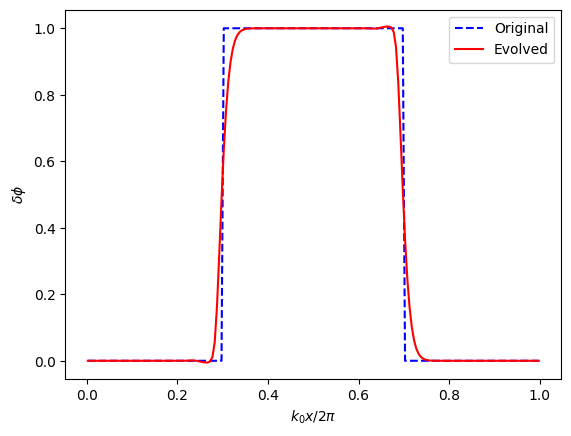

In [47]:
fig, ax1 = plt.subplots()
ax1.plot(XC,U0,color='blue',linestyle='--',label='Original')
ax1.plot(XC,U ,color='red',linestyle='-',label='Evolved')
ax1.set_xlabel('$k_0 x / 2\pi$',color='black')
ax1.set_ylabel('$\delta\phi$',color='black')
ax1.tick_params(axis='y', color='black')
ax1.legend(loc = 'upper right')
#ax1.legend(loc = 'lower left')
#ax1.legend(loc = 'upper left')